# Headline generation with finetuned pre-trained models(mBART and T5)



#### Contents

1. [Preparing Environment and Importing Libraries](#section01)
2. [Preparing the Dataset for data processing: Class](#section02)
3. [Fine Tuning the Model: Function](#section03)
4. [Validating the Model Performance: Function](#section04)
5. [Main Function](#section05)
    * [Creation of Dataset and Dataloader](#section503)
    * [Neural Network and Optimizer](#section504)
    * [Validation and generation of Summary](#section506)
6. [Examples of the Summary Generated from the model](#section06)


#### Technical Details


- **Data**:
	- We are using the News Summary dataset "shuffled_ria_dataset.json"
	- This dataset is the collection created from RBC news agency daily articles.
	- There are`1601` rows of data. Where each row has the following data-point:
		- **headline** : The headline of the article
		- **overview**: An annotation(caption) before the article itself
		- **body** : The actual full-text of the article
		- **category**: The category of the article
		- **tags**: The main tags related to the article


- **Language Model Used**: 
    - This notebook we will use transformers model ***T5***. [Research Paper](https://arxiv.org/abs/1910.10683)    
    - **Text-2-Text** - All NLP tasks are converted to a **text-to-text** problem. Tasks such as translation, classification, summarization and question answering, all of them are treated as a text-to-text problems.
	
   - [Documentation for python](https://huggingface.co/transformers/model_doc/t5.html)
 
	 

- **Objective**:
	- The objective is to fine tune ***T5*** to be able to generate summary, that is close to or better than the actual summary while ensuring the important information from the article is not lost.

In [ ]:
!pip install transformers -q
!pip install sentencepiece
!pip install rouge_score
# Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     |████████████████████████████████| 4.2 MB 8.5 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 596 kB 59.1 MB/s 
     |████████████████████████████████| 6.6 MB 50.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 8.0 MB/s 


In [ ]:
! pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.translate import bleu
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import json
import string
import numpy as np
import pandas as pd
import re
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer

from tqdm.notebook import tqdm
# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import MBartTokenizer, MBartForConditionalGeneration

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Checking out the GPU we have access to. This is output is from the google colab version. 
!nvidia-smi

Thu Jun 16 12:14:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

#### Useful insights

In [51]:
dataset = "enumerated_shuffled_rbc.json"
df = pd.read_json(dataset)

In [52]:
df = df.transpose()

In [53]:
df['articles_length'] = df['article_text'].apply(lambda x : len(x.split()))
df['headline_length'] = df['headline'].apply(lambda x : len(x.split()))

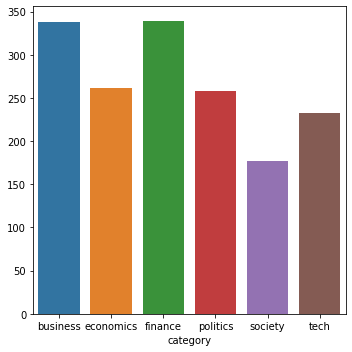

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
category_sizes = df.groupby('category').size()
plt.figure(figsize=(5,5))
sns.barplot(x=category_sizes.index, y= category_sizes)
plt.show()

In [ ]:
category_length = df.groupby('category',0).agg( {'articles_length':'mean', 'headline_length':'mean'} )
category_length

,articles_length,headline_length
category,,
business,586.275148,8.778107
economics,557.509579,8.969349
finance,612.622419,8.920354
politics,474.364341,9.116279
society,387.802260,9.000000
tech,536.077253,8.579399


In [ ]:
pd.melt(category_length,ignore_index=False).groupby('variable').mean()

,value
variable,
articles_length,525.775167
headline_length,8.893915


<a id='section02'></a>
### Preparing the Dataset for data processing: Class

We will start with creation of Dataset ***Prepare_Dataset*** class - This defines how the text is pre-processed before sending it to the neural network. This dataset will be used the the Dataloader method that will feed  the data in batches to the neural network for suitable training and processing. 
The Dataloader and Dataset will be used inside the `main()`. Which in-turns takes a pair of dataframe columns `(target, source_refrence)`
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *CustomDataset* Dataset Class
- This class is defined to accept the Dataframe as input and generate tokenized output that is used by the **T5** model for training. 
- We are using the **T5** tokenizer to tokenize the data in the `text` and `article_text` column of the dataframe. 
- The tokenizer uses the ` batch_encode_plus` method to perform tokenization and generate the necessary outputs, namely: `source_id`, `source_mask` from the actual text and `target_id` and `target_mask` from the summary text.
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/t5.html#t5tokenizer)
- The *Prepare_Dataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training. 

#### Dataloader: Called inside the `main()`
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of data loaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [ ]:
# Creating a custom dataset for reading the dataframe and loading it into the dataloader to pass it to the neural network at a later stage for finetuning the model and to prepare it for predictions

class Prepare_Dataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.summarization_target = self.data.iloc[:,0] # Assuming that the first column should always be the inteded task target
        self.article_text = self.data.article_text

    def __len__(self):
        return len(self.summarization_target)

    def __getitem__(self, index):
        article_text = str(self.article_text[index])
        article_text = ' '.join(article_text.split())

        summarization_target = str(self.summarization_target[index])
        summarization_target = ' '.join(summarization_target.split())

        source = self.tokenizer.batch_encode_plus([article_text], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([summarization_target], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

<a id='section03'></a>
### Fine Tuning the Model: Function

Training function that trains the model on the training dataset created above, specified number of times (EPOCHs), An epoch defines how many times the complete data will be passed through the network. 

This function is called in the `main(,)`

Following events happen in this function to fine tune the neural network:
- The epoch, tokenizer, model, device details, testing_ dataloader and optimizer are passed to the `train ()` when its called from the `main(,)`
- The dataloader passes data to the model based on the batch size.
- `language_model_labels` are calculated from the `target_ids` also, `source_id` and `attention_mask` are extracted.
- The model outputs first element gives the loss for the forward pass. 
- Loss value is used to optimize the weights of the neurons in the network.

In [ ]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we wnumerate over the training loader and passed to the defined network 

def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]
        
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        # xm.mark_step()

<a id='section04'></a>
### Validating the Model Performance: Function

During the validation stage we pass the unseen data(Testing Dataset), trained model, tokenizer and device details to the function to perform the validation run. This step generates new summary for dataset that it has not seen during the training session. 

This function is called in the `main()`

This unseen data is the 20% of `rbc_dataset.json` which was seperated during the Dataset creation stage. 
During the validation stage the weights of the model are not updated. We use the generate method for generating new text for the summary. 

It depends on the `Beam-Search coding` method developed for sequence generation for models with LM head. 

The generated text and originally summary are decoded from tokens to text and returned to the `main()`

In [ ]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actual_summaries = []
    actual_text = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            source_article = [tokenizer.decode(a, skip_special_tokens=True, clean_up_tokenization_spaces=True)for a in ids]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actual_summaries.extend(target)
            actual_text.extend(source_article)
    return predictions, actual_summaries, actual_text

<a id='section05'></a>
### Main Function

The `main()` as the name suggests is the central location to execute all the functions/flows created above in the notebook. The following steps are executed in the `main()`:


<a id='section502'></a>
#### Importing and Pre-Processing the domain data

We will be working with the data and preparing it for fine tuning purposes. 
*Assuming that the `_rbc_dataset.json`  is already downloaded in `dataset` folder*

* The file is imported as a dataframe and give it the headers as per the documentation.
* Cleaning the file to remove the unwanted columns.
* A new string is added to the main article column `summarize: ` prior to the actual article. This is done because **T5** had similar formatting for the summarization dataset. 
* The final Dataframe will be something like this:

|Generated Summary|Original Summary|Full Text of the article|
|--|--|--|
|summary-1|refrence summary-1| article 1|
|summary-2|refrence summary-2| article 2|
|summary-3|refrence summary-3| article 3|


<a id='section503'></a>
#### Creation of Dataset and Dataloader

* The updated dataframe is divided into 80-20 ratio for test and validation. 
* Both the data-frames are passed to the `Prepare Dataset` class for tokenization of the new articles and their summaries.
* The tokenization is done using the length parameters passed to the class.
* Train and Validation parameters are defined and passed to the `pytorch Dataloader contstruct` to create `train` and `validation` data loaders.
* These dataloaders will be passed to `train()` and `validate()` respectively for training and validation action.
* The shape of datasets is printed in the console.


<a id='section504'></a>
#### Neural Network and Optimizer

* In this stage we define the model and optimizer that will be used for training and to update the weights of the network. 
* We are using the `t5-base` transformer model for our project. You can read about the `T5 model` and its features above. 
* We use the `T5ForConditionalGeneration.from_pretrained("t5-base")` commad to define our model. The `T5ForConditionalGeneration` adds a Language Model head to our `T5 model`. The Language Model head allows us to generate text based on the training of `T5 model`.
* The `Adam` optimizer has been used in this project. 
* There is also a scope for doing more with Optimizer such a decay, momentum to dynamically update the Learning rate and other parameters.


<a id='section505'></a>
#### Training Model

* We call the `train()` with all the necessary parameters.
* Loss at every 500th step is printed on the console.


<a id='section506'></a>
#### Validation and generation of Summary

* After the training is completed, the validation step is initiated.
* As defined in the validation function, the model weights are not updated. We use the fine tuned model to generate new summaries based on the article text.
* An output is printed on the console giving a count of how many steps are complete after every 100th step. 
* The original summary and generated summary are converted into a list and returned to the main function. 
* Both the lists are used to create the final dataframe with 2 columns **Generated Summary** and **Actual Summary**
* The dataframe is saved as a csv file in the local drive.
* A qualitative analysis can be done with the Dataframe. 

In [ ]:
# Importing and Pre-Processing the domain data
# Selecting the needed columns only.
def select_pair(column_one, column_two, dataset):
    df = pd.read_json(dataset)
    df = df.transpose()
    df = df[[column_one, column_two]]
    return df

In [ ]:
def main(target_source_pair):

    TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
    VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
    TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    VAL_EPOCHS = 1 
    LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    SEED = 777               # random seed (default: 42)
    MAX_LEN = 512
    SUMMARY_LEN = 150 

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(SEED) # pytorch random seed
    np.random.seed(SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    MODEL_NAME = 'cointegrated/rut5-base-absum'

    rut5_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
    model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
    model = model.to(device)


    train_size = 0.8
    df = target_source_pair
    train_dataset=df.sample(frac=train_size, random_state = SEED).reset_index(drop=True)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    training_set = Prepare_Dataset(train_dataset, rut5_tokenizer, MAX_LEN, SUMMARY_LEN)
    val_set = Prepare_Dataset(val_dataset, rut5_tokenizer, MAX_LEN, SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)


    # Defining the optimizer that will be used to tune the weights of the network in the training session. 
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(TRAIN_EPOCHS):
        train(epoch, rut5_tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(VAL_EPOCHS):
        predictions, actual_summaries, actual_text = validate(epoch, rut5_tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'gen_summary':predictions,'ref_summary':actual_summaries, 'full_text':actual_text})
        final_df.to_csv("./outputs/predictions_{}.csv".format('_'.join(list(df.columns))))
        print('Output Files generated for review')

In [ ]:
summarization_target = 'headline'
source_text = 'article_text'
target_source_pair = select_pair(summarization_target, source_text, dataset)
if __name__ == '__main__':
    main(target_source_pair)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


FULL Dataset: (1606, 2)
TRAIN Dataset: (1285, 2)
TEST Dataset: (321, 2)
Initiating Fine-Tuning for the model on our dataset


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  4.781628608703613
Epoch: 0, Loss:  1.3164842128753662
Epoch: 1, Loss:  2.29260516166687
Epoch: 1, Loss:  0.8891348838806152
Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe
Completed 0
Completed 100
Output Files generated for review


In [ ]:
df_summary = pd.read_csv('./outputs/predictions_headline_article_text.csv', index_col=0)
no_duplicates = df_summary[~df_summary.gen_summary.isin(df_summary.ref_summary)]

In [ ]:
len(df_summary.index), len(no_duplicates.index)

(321, 317)

##### Only four articles got a summarization that is identical to the original headline

## **mBART Pre-trained model**

<a id='section06'></a>
### Evaluation with ROUGE and BLEU metrics

* ROUGE is a proxy metric for abstractive summarization.
* In practice one of the most common metrics used to measure the performance of a summarization model is called the ROUGE score (Recall-Oriented Understudy for Gisting Evaluation) 
* The algorithm to compute ROUGE score considers consecutive tokens i.e. n-grams.
* The n-grams from one text (e.g. the human-written summary) are compared to the n-grams of the other text (e.g. the machine-written summary).
* A large overlap of n-grams results in a high ROUGE score and a low overlap — in a low ROUGE score. 
* For text summarization we want to look at ROUGE longest common subsequence (ROUGE L) as this will give us the longest overlap.
* For the ROGUE we know it uses both recall and precision, and also the F1 score which is the harmonic mean of these.
* For BLEU, well it also use precision twinned with recall but uses geometric mean and brevity penalty.
* The difference between the ROUGE-n precision and BLEU is that BLEU introduces a brevity penalty term, and also compute the n-gram match for several size of n-grams (unlike the ROUGE-n, where there is only one chosen n-gram size). A good answer (https://stackoverflow.com/a/39190391/12178630)

In [ ]:
model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.23G [00:00<?, ?B/s]

In [ ]:
def gen_batch(inputs, batch_size):
    batch_start = 0
    while batch_start < len(inputs):
        yield inputs[batch_start: batch_start + batch_size]
        batch_start += batch_size

In [12]:
def predict(
    tokenizer,
    model,
    test_file,
    max_article_tokens_count=1000,
    max_refrence_tokens_count=20,
    use_cuda=True,
    batch_size=4
):
    df = pd.read_json(test_file)
    df = df.transpose()
    inputs = list(df['article_text'])
    refrences = list(df['headline'])

    device = torch.device("cuda:0") if use_cuda else torch.device("cpu")
    
    predictions = []
    for batch in tqdm(gen_batch(inputs, batch_size)):
        input_ids = tokenizer.prepare_seq2seq_batch(
            batch,
            src_lang="ru_RU",
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_article_tokens_count)["input_ids"].to(device)
        output_ids = model.generate(
            input_ids=input_ids,
            max_length=max_refrence_tokens_count + 2,
            no_repeat_ngram_size=3,
            num_beams=5,
            top_k=0
        )
        summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        predictions.extend(summaries)

    summary_df = pd.DataFrame({'gen_summary':predictions,'ref_summary':refrences, 'full_text':inputs})
    return summary_df

In [13]:
df_summary = predict(tokenizer, model, dataset)

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3538: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


,gen_summary,ref_summary,full_text
0,В Запорожскую область отправлено 11 вагонов с ...,Песков заявил об отсутствии соглашений по укра...,Об отправке 11 вагонов с зерном для продажи ...
1,Владимир Зеленский «не хотел слышать» предупре...,В Киеве попросили уточнить слова Байдена об от...,Западные страны не стали вводить превентивны...
2,В случае дефолта «Роснано» для всех госкомпани...,Владелец бондов «Роснано» назвал возможный деф...,"По мнению гендиректора «Арикапитала», если г..."
3,«Тинькофф» Олега Тинькова планирует выходить н...,«Тинькофф» описал схему выхода на новые рынки ...,Группа Олега Тинькова планирует выходить на ...
4,Верховный суд России внес в правительство прое...,"Верховный суд даст разъяснение, что считать пр...",Слишком длительные допросы и оскорбления мог...
...,...,...,...
1601,"Банк Сбербанка заработал 978,1 млрд руб. за де...",Чистая прибыль Сбербанка приблизилась к ₽1 трлн,Банк за три квартала почти смог достичь годо...
1602,Президент Европейского центрального банка Крис...,Глава Центробанка Европы призвала регулировать...,Она указала на риски вложения в криптовалюты...
1603,Бывший премьер-министр Франции Франсуа Фийон в...,Экс-премьер Франции Фийон вошел в совет директ...,Новыми членами совета директоров компании ст...
1604,«Сафмар» Михаила Гуцериева приостановил работу...,Marriott решила приостановить деятельность в Р...,"Marriott признала, что процесс приостановки ..."


In [25]:
df_summary.to_csv("mbart_{}.csv".format('_'.join(list(df_summary.columns))))

# **Evaluation of T5 and mBART summaries**

In [9]:
from evaluate import calculate_Bleu_Score, calculate_Rouge_Score, evalute_sample_from_dataset
from plot_eval import plot_rouge, plot_bleu

### **Evaluating T5 summaries**

In [4]:
summary_datafile = 'predictions_headline_article_text.csv'

In [7]:
bleu_scores, rouge1_scores, rouge2_scores, rougeL_scores, rougeLsum_scores = evalute_sample_from_dataset(summary_datafile, 300)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Final Blue Scores [[0.32640934 0.18925453 0.12733808]]
Final ROUGE1 Scores [[0.17722222 0.16638889 0.16538095]]
Final ROUGE2 Scores [[0.04111111 0.04444444 0.04144444]]
Final ROUGEL Scores [[0.17722222 0.16638889 0.16538095]]
Final ROUGELsum Scores [[0.17722222 0.16638889 0.16538095]]


In [10]:
rouge_eval = []
rouge_eval.append(rouge1_scores[0].tolist())
rouge_eval.append(rouge2_scores[0].tolist())
rouge_eval.append(rougeL_scores[0].tolist())
rouge_eval.append(rougeLsum_scores[0].tolist())

rouge_eval = (np.array(rouge_eval))

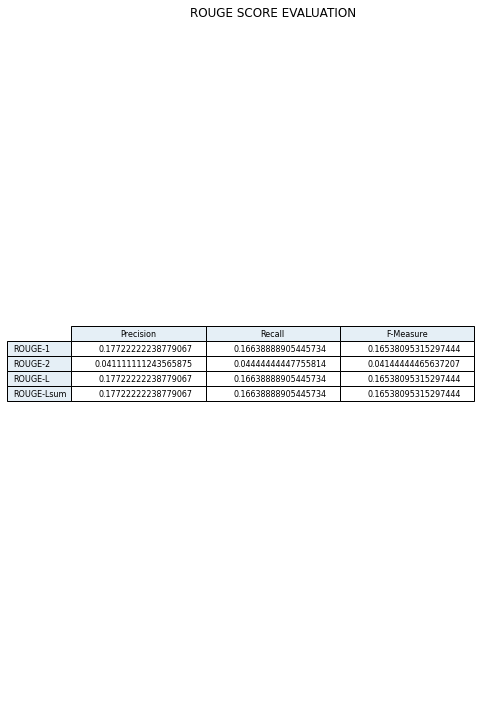

In [11]:
plot_rouge(rouge_eval)

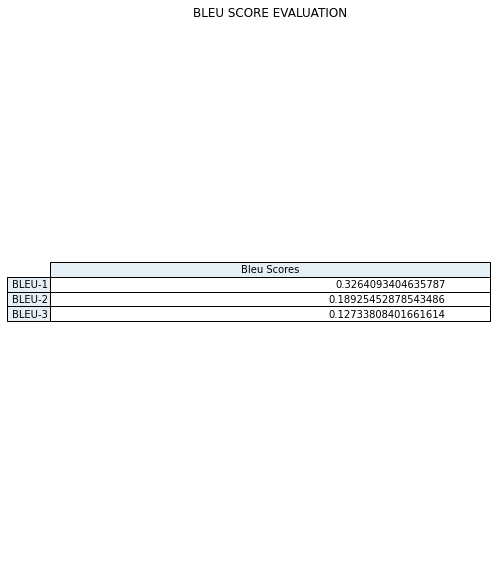

In [12]:
plot_bleu(bleu_scores)

### **Evaluating mBART summaries**

In [16]:
summary_datafile = 'mbart_gen_summary_ref_summary_full_text.csv'

In [18]:
bleu_scores, rouge1_scores, rouge2_scores, rougeL_scores, rougeLsum_scores = evalute_sample_from_dataset(summary_datafile, 300)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Final Blue Scores [[0.22734489 0.09983469 0.05525172]]
Final ROUGE1 Scores [[0.1175     0.11003175 0.10901058]]
Final ROUGE2 Scores [[0.02888889 0.02944444 0.02844444]]
Final ROUGEL Scores [[0.1175     0.11003175 0.10901058]]
Final ROUGELsum Scores [[0.1175     0.11003175 0.10901058]]


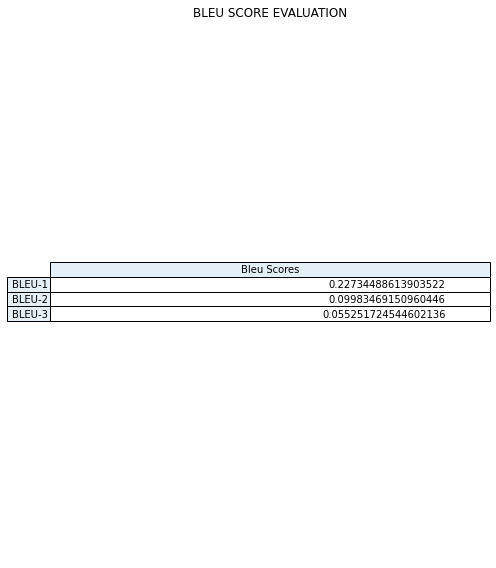

In [19]:
plot_bleu(bleu_scores)

In [20]:
rouge_eval = []
rouge_eval.append(rouge1_scores[0].tolist())
rouge_eval.append(rouge2_scores[0].tolist())
rouge_eval.append(rougeL_scores[0].tolist())
rouge_eval.append(rougeLsum_scores[0].tolist())

rouge_eval = (np.array(rouge_eval))

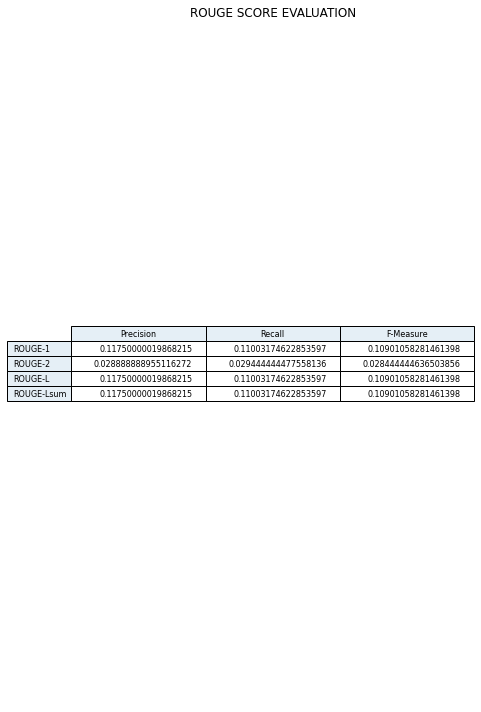

In [21]:
plot_rouge(rouge_eval)